# Stock LSTM

## Improvements Needed:  
1. Null Hypothesis: 'tomorrow will look like today'.  
    - create null hypothesis of assuming last days price.  
    - compare results with how the model compares to the null hypothesis.  
    - extend architecture or customize the cost funciton to train model against null hypothesis.  
        - assuming yesterdays price, which way will volatility take us?  
<br>
2. Generalize Market Movement.  
    - take in a list of stocks that provide context.  
    - preprocess each stock's history and append together.  
    - train all stocks to predict tomorrows price of one stock.  
    - funcitonalize the code in the beginning to view output.  
<br>
3. Compare against other model methodologies.  
    - Define other model architecture to compare relative performances.  

In [107]:
import pandas as pd

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['GOOG', 'MSFT', 'SPY']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2012-10-01'
end_date = '2022-10-01'


import yfinance as yf #df = yf.Ticker('goog').history(interval='15m', start='2012-09-10', end='2022-09-10')
import pandas_datareader as pdr
raw_data = pdr.DataReader(tickers, 'yahoo', start_date, end_date)
raw_data

Attributes   Adj Close                               Close              \
Symbols           GOOG        MSFT         SPY        GOOG        MSFT   
Date                                                                     
2012-10-01   18.973383   24.118452  119.590263   18.973383   29.490000   
2012-10-02   18.854080   24.257484  119.714561   18.854080   29.660000   
2012-10-03   18.991316   24.421055  120.203384   18.991316   29.860001   
2012-10-04   19.129547   24.560089  121.064972   19.129547   30.030001   
2012-10-05   19.119585   24.412872  121.073250   19.119585   29.850000   
...                ...         ...         ...         ...         ...   
2022-09-26   98.809998  236.782700  364.309998   98.809998  237.449997   
2022-09-27   98.089996  235.745636  363.380005   98.089996  236.410004   
2022-09-28  100.739998  240.392548  370.529999  100.739998  241.070007   
2022-09-29   98.089996  236.832565  362.790009   98.089996  237.500000   
2022-09-30   96.150002  232.245483  357.179993   96.150002  232.899994   

Attributes                    High                                Low  \
Symbols            SPY        GOOG        MSFT         SPY       GOOG   
Date                                                                    
2012-10-01  144.350006   19.053581   29.980000  145.690002  18.834654   
2012-10-02  144.500000   19.078239   29.889999  145.149994  18.686708   
2012-10-03  145.089996   19.026684   29.990000  145.429993  18.734777   
2012-10-04  146.130005   19.175377   30.030001  146.339996  18.914104   
2012-10-05  146.139999   19.287207   30.250000  147.160004  19.053831   
...                ...         ...         ...         ...        ...   
2022-09-26  364.309998  100.440002  241.449997  370.209991  98.379997   
2022-09-27  363.380005  100.459999  241.800003  370.399994  97.339996   
2022-09-28  370.529999  101.400002  242.330002  372.299988  97.800003   
2022-09-29  362.790009   99.300003  239.949997  367.109985  96.519997   
2022-09-30  357.179993   99.494003  240.539993  365.910004  96.029999   

Attributes                               Open                          \
Symbols           MSFT         SPY       GOOG        MSFT         SPY   
Date                                                                    
2012-10-01   29.420000  144.009995  18.905388   29.809999  144.520004   
2012-10-02   29.500000  143.830002  19.058563   29.680000  144.919998   
2012-10-03   29.670000  144.130005  18.822449   29.750000  144.889999   
2012-10-04   29.570000  145.440002  18.997543   29.969999  145.639999   
2012-10-05   29.740000  145.699997  19.195799   30.230000  146.910004   
...                ...         ...        ...         ...         ...   
2022-09-26  236.899994  363.029999  98.610001  237.050003  366.410004   
2022-09-27  234.500000  360.869995  99.910004  239.979996  368.019989   
2022-09-28  234.729996  362.600006  98.019997  236.809998  364.380005   
2022-09-29  234.410004  359.700012  99.300003  238.889999  366.809998   
2022-09-30  232.729996  357.040009  97.730003  238.289993  361.799988   

Attributes       Volume                           
Symbols            GOOG        MSFT          SPY  
Date                                              
2012-10-01  127194978.0  54042700.0  135911200.0  
2012-10-02  112026334.0  43338900.0  113422200.0  
2012-10-03   88663090.0  46655900.0  121283100.0  
2012-10-04   98535958.0  43634900.0  124311600.0  
2012-10-05  109846193.0  41133900.0  124842100.0  
...                 ...         ...          ...  
2022-09-26   22437900.0  27694200.0   92581200.0  
2022-09-27   24225000.0  27018700.0  108294100.0  
2022-09-28   24617000.0  29029700.0  110802200.0  
2022-09-29   21921500.0  27484200.0  112952300.0  
2022-09-30   26277800.0  35694800.0  153711200.0  

[2517 rows x 18 columns]

## Explore Data

In [108]:
# Getting just the adjusted closing prices.
data = raw_data['Close']

# Getting all weekdays
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# Filling in the weekends with the latest price
data = data.reindex(all_weekdays).fillna(method='ffill')
data.dropna(inplace=True)

data.describe()

Symbols,GOOG,MSFT,SPY
count,2610.000000,2610.000000,2610.000000
mean,57.315619,116.419954,267.808567
std,35.232347,88.917631,87.413459
min,16.119081,26.370001,135.699997
25%,28.843434,46.102499,201.937500
50%,48.638000,75.185001,247.970001
75%,69.699627,173.962502,312.807487
max,150.709000,343.109985,477.709991


In [1]:
def visualize_equity(df, ticker):
    # Get the MSFT timeseries. This now returns a Pandas Series object indexed by date.
    data = df.loc[:, ticker]

    # Calculate the 20 and 100 days moving averages of the closing prices
    short_rolling = data.rolling(window=20).mean()
    long_rolling = data.rolling(window=100).mean()

    # Identify dates as datetimes
    def str_to_datetime(s):
        import datetime
        split = s.split('-')
        year, month, day = int(split[0]), int(split[1]), int(split[2])
        return datetime.datetime(year=year, month=month, day=day)

    if (data.index.dtype != '' and data.index.dtype != 'datetime64[ns]'):
        data.reset_index(inplace=True)
        data['Date'] = data['Date'].apply(str_to_datetime)
    else: 
        print('Date is already Datetime')
    
    # Plot everything
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 16, 'font.weight': 'bold', 'font.weight':'bold', 'figure.figsize': (16,9)})
    fig, ax = plt.subplots(figsize=(16,9))

    ax.plot(idx.index, idx, label=ticker, color='navy')
    ax.plot(short_rolling_idx.index, short_rolling_idx, color='violet', label='20 days rolling')
    ax.plot(long_rolling_idx.index, long_rolling_idx, color='red', label='100 days rolling')

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price ($)')
    ax.set_facecolor('#E6E6E6')
    ax.legend()
    plt.show()

for ticker in tickers:
    visualize_equity(data, ticker)

NameError: name 'tickers' is not defined

## Preprocess Data

In [110]:
data

Symbols,GOOG,MSFT,SPY
2012-10-01,18.973383,29.490000,144.350006
2012-10-02,18.854080,29.660000,144.500000
2012-10-03,18.991316,29.860001,145.089996
2012-10-04,19.129547,30.030001,146.130005
2012-10-05,19.119585,29.850000,146.139999
...,...,...,...
2022-09-26,98.809998,237.449997,364.309998
2022-09-27,98.089996,236.410004,363.380005
2022-09-28,100.739998,241.070007,370.529999
2022-09-29,98.089996,237.500000,362.790009


Date is already Datetime


In [112]:
## Normalize
import numpy as np
from sklearn.preprocessing import StandardScaler

# Size of the training set
train_size=0.8

# Standard Scale by fitting on train size
def scale_dataframe(df, train_size=0.8):
	def scale_columns(df, columns, scalers):
		import warnings
		warnings.filterwarnings("ignore")

		if scalers is None:
			scalers = {}
			for col in columns:
				scaler = StandardScaler().fit(df[[col]])
				df[col] = scaler.transform(df[[col]])
				scalers[col] = scaler
	
		else:
			for col in columns:
				scaler = scalers.get(col)
				df[col] = scaler.transform(df[[col]])

		return df, scalers

	train_sample=data.iloc[:int((len(df)*train_size)-1),:]
	test_sample=data.iloc[int((len(df)*train_size)-1):,:]
	scaled_train, scalers = scale_columns(train_sample, tickers, scalers=None)
	scaled_test, scalers = scale_columns(test_sample, tickers, scalers=scalers)
	scaled_df = pd.concat([scaled_train.dropna(), scaled_test.dropna()])

	import math
	for scale in scalers:
		print(scale, 'Mean: %f, StandardDeviation: %f' % (scalers[scale].mean_, math.sqrt(scalers[scale].var_)))
	return scaled_df, scalers

scaled_df, scalers = scale_dataframe(data, train_size)
scaled_df

GOOG Mean: 41.926305, StandardDeviation: 16.337032
MSFT Mean: 78.195223, StandardDeviation: 47.611057
SPY Mean: 231.277757, StandardDeviation: 50.747158


Symbols,GOOG,MSFT,SPY
2012-10-01,-1.404963,-1.022981,-1.712958
2012-10-02,-1.412265,-1.019411,-1.710002
2012-10-03,-1.403865,-1.015210,-1.698376
2012-10-04,-1.395404,-1.011639,-1.677882
2012-10-05,-1.396014,-1.015420,-1.677685
...,...,...,...
2022-09-26,3.481887,3.344912,2.621472
2022-09-27,3.437815,3.323068,2.603146
2022-09-28,3.600023,3.420945,2.744040
2022-09-29,3.437815,3.345962,2.591520


In [113]:
## Rephrase (normalize and window)

# Define Metadata
ticker='MSFT'
scaler=scalers[ticker]###
df=pd.DataFrame(data[ticker])###

X_timesteps=50
start_date='2016-10-01'
end_date='2020-10-01'

# Phrase the data as the info considered in a daily window of time
def df_to_windowed_df(dataframe, target_name, first_date_str, last_date_str, X_timesteps=3):
    import numpy as np
    import datetime

    # Make input dates datetimes
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    # Start with the first date...
    target_date = first_date

    # and build windowed_df for every date after
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(X_timesteps+1)

        if len(df_subset) != X_timesteps+1:
            print(f'Error: Window of size {X_timesteps} is too large for date {target_date}')
            return

        # Format window
        values = df_subset[target_name].to_numpy()
        x, y = values[:-1], values[-1]

        # Append new window
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # str input-to-datetime
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=5)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        # Stop when on last date
        if last_time:
            break
        
        # Shift to next date
        target_date = next_date

        if target_date == last_date:
            last_time = True

    # Build new windowed df
    ## Date index
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    ## X windows
    X = np.array(X)
    for i in range(0, X_timesteps):
        X[:, i]
        ret_df[f'Target-{X_timesteps-i}'] = X[:, i]
    
    ## Y - target var
    ret_df['Target'] = Y

    return ret_df

windowed_df = df_to_windowed_df(scaled_df,ticker,start_date,end_date,X_timesteps)
windowed_df

,Target Date,Target-50,Target-49,Target-48,Target-47,Target-46,Target-45,Target-44,Target-43,Target-42,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2016-10-01,-0.454206,-0.450845,-0.450215,-0.462187,-0.461767,-0.451896,-0.453996,-0.453996,-0.445804,...,-0.446645,-0.449165,-0.429212,-0.427952,-0.436143,-0.447275,-0.425221,-0.423541,-0.436773,-0.432572
1,2016-10-04,-0.450215,-0.462187,-0.461767,-0.451896,-0.453996,-0.453996,-0.445804,-0.436983,-0.425011,...,-0.429212,-0.427952,-0.436143,-0.447275,-0.425221,-0.423541,-0.436773,-0.432572,-0.436353,-0.440134
2,2016-10-05,-0.462187,-0.461767,-0.451896,-0.453996,-0.453996,-0.445804,-0.436983,-0.425011,-0.422911,...,-0.427952,-0.436143,-0.447275,-0.425221,-0.423541,-0.436773,-0.432572,-0.436353,-0.440134,-0.431732
3,2016-10-06,-0.461767,-0.451896,-0.453996,-0.453996,-0.445804,-0.436983,-0.425011,-0.422911,-0.419970,...,-0.436143,-0.447275,-0.425221,-0.423541,-0.436773,-0.432572,-0.436353,-0.440134,-0.431732,-0.429632
4,2016-10-07,-0.451896,-0.453996,-0.453996,-0.445804,-0.436983,-0.425011,-0.422911,-0.419970,-0.423751,...,-0.447275,-0.425221,-0.423541,-0.436773,-0.432572,-0.436353,-0.440134,-0.431732,-0.429632,-0.428372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,2020-09-25,2.618820,2.801971,2.742110,2.805121,2.611678,2.585634,2.639193,2.600757,2.643604,...,2.671959,2.742741,2.664397,2.619450,2.566521,2.611678,2.714176,2.570722,2.625331,2.722577
1040,2020-09-28,2.801971,2.742110,2.805121,2.611678,2.585634,2.639193,2.600757,2.643604,2.640243,...,2.742741,2.664397,2.619450,2.566521,2.611678,2.714176,2.570722,2.625331,2.722577,2.756603
1041,2020-09-29,2.742110,2.805121,2.611678,2.585634,2.639193,2.600757,2.643604,2.640243,2.663557,...,2.664397,2.619450,2.566521,2.611678,2.714176,2.570722,2.625331,2.722577,2.756603,2.710815
1042,2020-09-30,2.805121,2.611678,2.585634,2.639193,2.600757,2.643604,2.640243,2.663557,2.905728,...,2.619450,2.566521,2.611678,2.714176,2.570722,2.625331,2.722577,2.756603,2.710815,2.775296


In [114]:
# Resize

# Splits the df into three cruicial tensor components: (the date, input, target)
def windowed_df_to_date_X_y(windowed_dataframe, number_of_y_vars=1):
    import numpy as np
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0] #dates kept in first column, not as index

    middle_matrix = df_as_np[:, 1:-number_of_y_vars] #all x (after dates, before y)
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], number_of_y_vars))

    Y = df_as_np[:, -number_of_y_vars:]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1044,), (1044, 50, 1), (1044, 1))

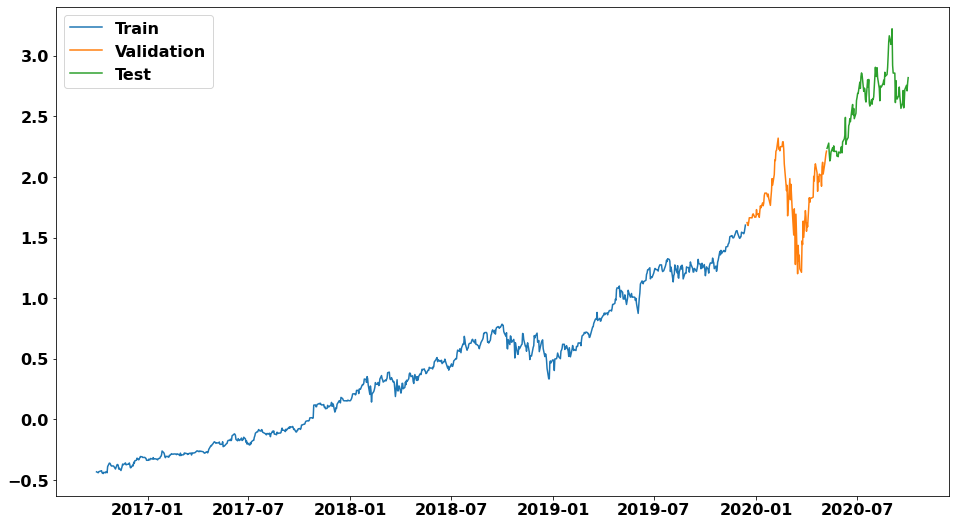

In [115]:
# Regroup

# Split for 80% train, 10% validation, 10% test
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.show()

## Train LSTM NN Model

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, callbacks

# Custom Cost Function
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

# Custom learning rate
learning_rate=0.001
def updateLearningRate(epoch):
    if(epoch==3):
        return learning_rate*0.5
    if(epoch==5):
        return learning_rate*0.5
    else:
        return learning_rate

# Callback logging
my_callbacks = [
    callbacks.EarlyStopping(patience=4),
    callbacks.ModelCheckpoint(monitor='val_mean_absolute_error',
                                mode='min',
                                save_best_only=True,
                                #save_weights_only=True,
                                filepath='logs/model.{epoch:02d}-{val_mean_absolute_error:.2f}.h5'),
    callbacks.TensorBoard(log_dir='./logs'),
    callbacks.LearningRateScheduler(updateLearningRate, verbose=0)
]

# Custom model architecture
model = Sequential([layers.Input((X_timesteps, 1)),
                    layers.LSTM(X_timesteps*2, return_sequences=True),
                    layers.LSTM(X_timesteps*2, return_sequences=False),
                    layers.Dense(X_timesteps*0.5, activation='relu'),
                    layers.Dense(1)])

model.compile(loss=root_mean_squared_error,  
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size=1, epochs=100, 
                    callbacks=[my_callbacks])

Epoch 1/100
835/835 [==============================] - 20s 19ms/step - loss: 0.0853 - mean_absolute_error: 0.0853 - val_loss: 0.1004 - val_mean_absolute_error: 0.1004 - lr: 0.0020
Epoch 2/100
835/835 [==============================] - 17s 20ms/step - loss: 0.0489 - mean_absolute_error: 0.0489 - val_loss: 0.1145 - val_mean_absolute_error: 0.1145 - lr: 0.0020
Epoch 3/100
835/835 [==============================] - 17s 20ms/step - loss: 0.0475 - mean_absolute_error: 0.0475 - val_loss: 0.1683 - val_mean_absolute_error: 0.1683 - lr: 0.0020
Epoch 4/100
835/835 [==============================] - 18s 22ms/step - loss: 0.0241 - mean_absolute_error: 0.0241 - val_loss: 0.1301 - val_mean_absolute_error: 0.1301 - lr: 4.0000e-04
Epoch 5/100
835/835 [==============================] - 18s 22ms/step - loss: 0.0456 - mean_absolute_error: 0.0456 - val_loss: 0.1415 - val_mean_absolute_error: 0.1415 - lr: 0.0020


## Evaluate Performance

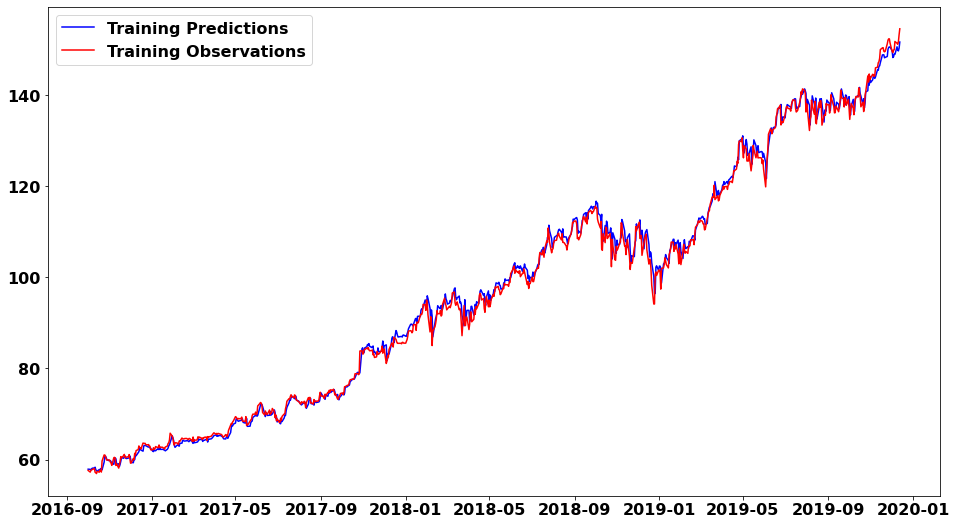

In [118]:
train_predictions = model.predict(X_train).flatten()
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1,1))

plt.plot(dates_train, train_predictions, color='blue')
plt.plot(dates_train, y_train, color='red')
plt.legend(['Training Predictions', 'Training Observations'])
plt.show()

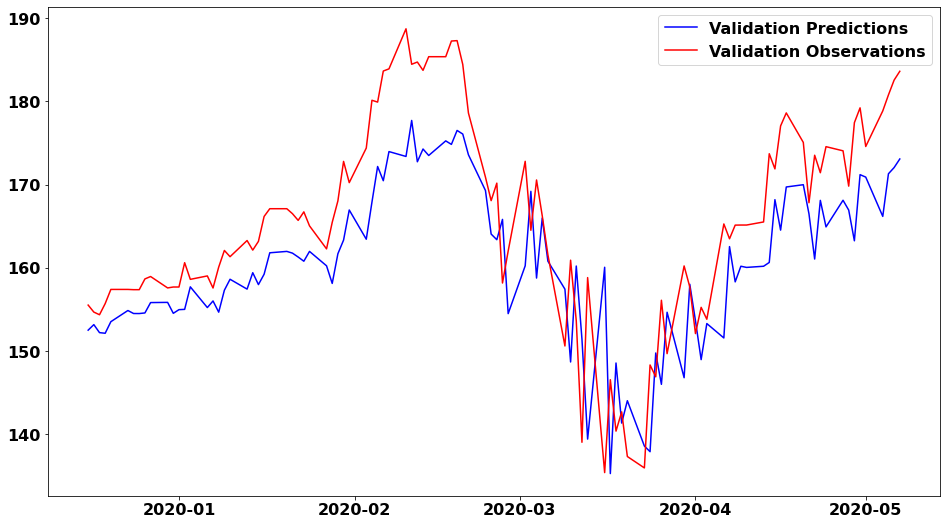

In [119]:
val_predictions = model.predict(X_val).flatten()
y_val = scaler.inverse_transform(y_val.reshape(-1,1))
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1,1))

plt.plot(dates_val, val_predictions, color='blue')
plt.plot(dates_val, y_val, color='red')
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.show()

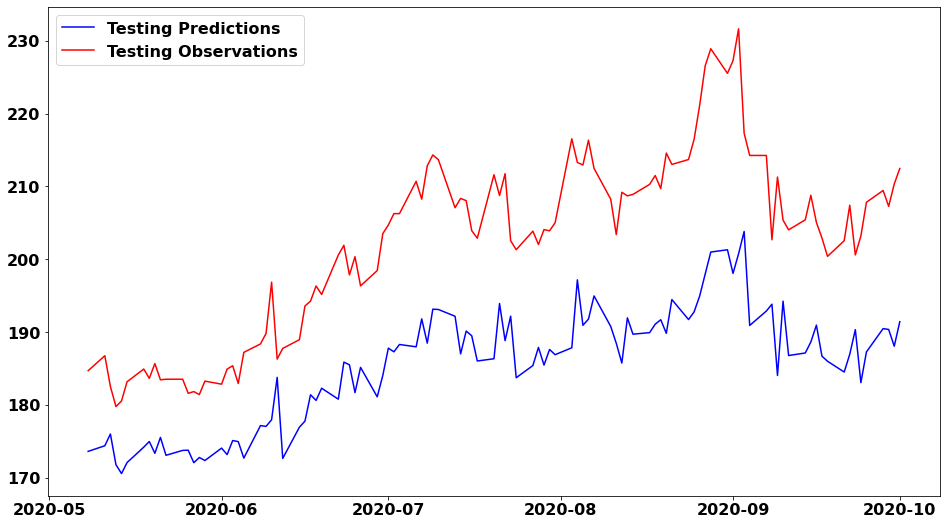

In [120]:
test_predictions = model.predict(X_test).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1,1))

plt.plot(dates_test, test_predictions, color='blue')
plt.plot(dates_test, y_test, color='red')
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.show()

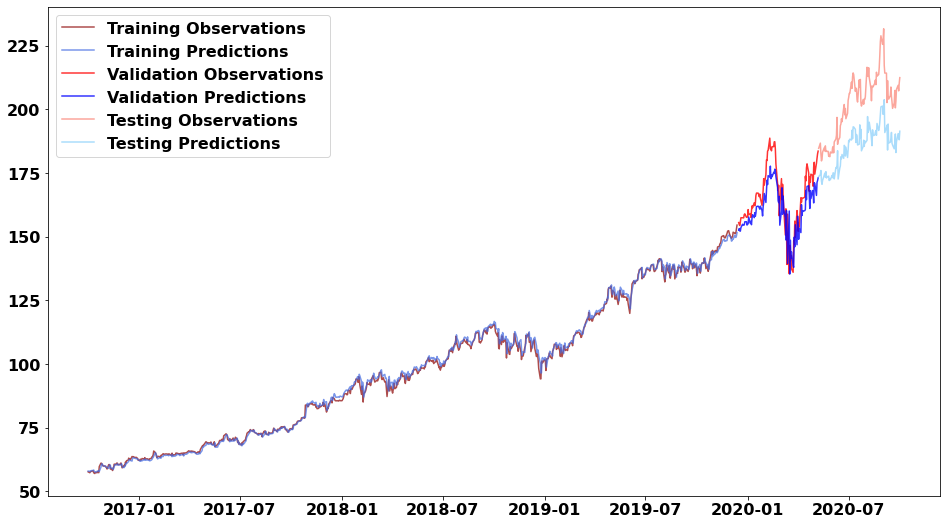

In [121]:
plt.plot(dates_train, y_train, color='darkred', alpha=0.7)
plt.plot(dates_train, train_predictions, color='royalblue', alpha=0.7)
plt.plot(dates_val, y_val, color='red', alpha=0.8)
plt.plot(dates_val, val_predictions, color='blue', alpha=0.8)
plt.plot(dates_test, y_test, color='salmon', alpha=0.7)
plt.plot(dates_test, test_predictions, color='lightskyblue', alpha=0.7)
plt.legend(['Training Observations',
            'Training Predictions', 
            'Validation Observations',
            'Validation Predictions', 
            'Testing Observations',
            'Testing Predictions'])
plt.show()